# **Cross-validation for algorithm selection** 



In order to make sure that your algorithm is efficient and robust, it is necessary to measure its generalization performance. Here, we will illustrate how to perform  algorithmic selection using nested cross-validation. We will use the German credit dataset as an example. 

In this notebook, we will:
1. Load and organize the data 
2. Pre-process the features  
3. Perform algorithm selection thorugh nested cross-validation
4. Show the results 

We will implement the SVC and the cross-validation in [scikit-learn](https://scikit-learn.org/stable/). 


## **Load and Organise data**

In [ ]:
#requirements !pip freeze > requirements.txt.
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Please download the data from the following link: https://drive.google.com/file/d/1t_knbnXYYD7LZopHVc2H2DBm4QId4FEf/view?usp=sharing. If running in Colab, please upload the data to the local folder. Otherwise, place the data in the same folder as the notebook.

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/askoshiyama/mli-cohort/master/german_credit.csv")
df.head()

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


## **Pre-process variables**

We start by observing which variables are in the dataset, then transform the categorical variables in binary values through one hot encoding. 

In [ ]:
# variable types
df.dtypes

default                        int64
account_check_status          object
duration_in_month              int64
credit_history                object
purpose                       object
credit_amount                  int64
savings                       object
present_emp_since             object
installment_as_income_perc     int64
personal_status_sex           object
other_debtors                 object
present_res_since              int64
property                      object
age                            int64
other_installment_plans       object
housing                       object
credits_this_bank              int64
job                           object
people_under_maintenance       int64
telephone                     object
foreign_worker                object
dtype: object

In [ ]:
# categorical variables
cat_variables = ['account_check_status', 'credit_history', 'purpose', 'savings', 'present_emp_since', 'personal_status_sex',
                'property', 'other_installment_plans', 'housing', 'job', 'telephone', "other_debtors", 'foreign_worker']

# target variable
output_variable = ["default"]

# other integer variables
int_variables = ['credits_this_bank', 'present_res_since', 'duration_in_month', 'people_under_maintenance', 
                 'installment_as_income_perc', 'age', 'credit_amount']

In [ ]:
# pre-allocation
df_cat = pd.DataFrame(index=df.index)

# one-hot encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

# I will do a loop for pedagogical reasons, but it is not entirely necessary
for cat in cat_variables:
    # one-hot encoding fitting
    one_hot_func = OneHotEncoder().fit(df[[cat]])
    
    # mapping
    cat_mapped = one_hot_func.transform(df[[cat]]).toarray()
    
    # storing
    for (k, cat_label) in enumerate(one_hot_func.categories_[0]):
        df_cat[cat + "_" + cat_label] = cat_mapped[:, k]

We then bin the variable age into three categories: young, adult, senior.

In [ ]:
# bracketing integer variable - age
from sklearn.preprocessing import KBinsDiscretizer
kbin_func = KBinsDiscretizer(n_bins=3, encode='onehot', strategy='quantile').fit(df[["age"]])
df_age = pd.DataFrame(kbin_func.transform(df[["age"]]).toarray(), columns=["young", "adult", "senior"])

# checking
pd.concat([df_age, df[["age"]]], axis=1).head(10)

,young,adult,senior,age
0,0.0,0.0,1.0,67
1,1.0,0.0,0.0,22
2,0.0,0.0,1.0,49
3,0.0,0.0,1.0,45
4,0.0,0.0,1.0,53
5,0.0,1.0,0.0,35
6,0.0,0.0,1.0,53
7,0.0,1.0,0.0,35
8,0.0,0.0,1.0,61
9,0.0,1.0,0.0,28


We also add the log-transformed variables to the datset. 

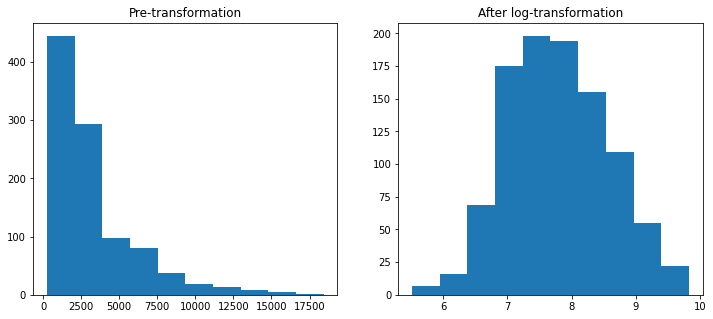

In [ ]:
# other types of transformations possible - log transformation 
from sklearn.preprocessing import FunctionTransformer
log_mapping = FunctionTransformer(func=np.log, inverse_func=np.exp)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(df["credit_amount"])
ax1.set_title("Pre-transformation")

ax2.hist(log_mapping.transform(df["credit_amount"]))
ax2.set_title("After log-transformation")
df_log = pd.DataFrame(log_mapping.transform(df["credit_amount"]).values, columns=["log(credit)"])

Finally, we can finalize and print our dataset

In [ ]:
df_model = pd.concat([df[int_variables[:-2]], df_cat, df_age, df_log, df[output_variable]], axis=1)
df_model.head()

,credits_this_bank,present_res_since,duration_in_month,people_under_maintenance,installment_as_income_perc,account_check_status_0 <= ... < 200 DM,account_check_status_< 0 DM,account_check_status_>= 200 DM / salary assignments for at least 1 year,account_check_status_no checking account,credit_history_all credits at this bank paid back duly,...,other_debtors_co-applicant,other_debtors_guarantor,other_debtors_none,foreign_worker_no,foreign_worker_yes,young,adult,senior,log(credit),default
0,2,4,6,1,4,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.063904,0
1,1,2,48,1,2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,8.691315,1
2,1,3,12,2,2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,7.647786,0
3,1,4,42,2,2,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.972337,0
4,2,4,24,2,3,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,8.490849,1


## **Algorithm selection**

First, we define the list of our models and their hyperparameters: Gradient Boosting Classifier, Decision Tree, MultiLayer Perceptron, k-Nearest Neighbour, Logistic Regression, Lasso, Elastic Net, SVM, and two baseline classifiers which predict the label at random, uniformly or respective to the class distribution in the training set. 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


# models
model_dict = {"GBT": GradientBoostingClassifier(random_state=10),
              "Tree": DecisionTreeClassifier(random_state=10),
              "MLP": Pipeline([("std", StandardScaler()), 
                               ("mlp", MLPClassifier(random_state=10))]),
              "KNN": Pipeline([("std", StandardScaler()),
                               ("knn", KNeighborsClassifier())]),
              "Logistic": LogisticRegression(penalty="none", solver="lbfgs"),
              "LassoLogistic": Pipeline([("std", StandardScaler()), 
                                         ("lasso", LogisticRegression(penalty="l1", solver='liblinear'))]),
              "ElasticNet": Pipeline([("std", StandardScaler()), 
                                      ("en", LogisticRegression(penalty="elasticnet", solver="saga"))]),
              "UnifRandom": DummyClassifier(strategy="uniform"), 
              "StratRandom": DummyClassifier(strategy="stratified"),
              "SVM": Pipeline([("std", StandardScaler()), 
                               ("svc", SVC(kernel="rbf", probability=True))]),
             }

# models hyperparams
hyper_params = {"GBT": {"learning_rate": [10.0 ** -1, 10.0 ** 0, 2.0],
                        "max_depth": [1, 2, 3],
                        "max_features": [0.1, 0.25, 0.5],
                        "n_estimators": [200]},
                "Tree": {"max_depth": [1, 3, 5, 7, 9],
                         "class_weight": [None, "balanced"]},
                "MLP": {"mlp__hidden_layer_sizes": [(5,), (10,), (50,)], 
                        "mlp__activation": ['relu', 'tanh']
                       },
                "KNN": {"knn__n_neighbors": [1, 3, 5, 7]
                       },
                "Logistic": {"class_weight": [None, "balanced"]},
                "LassoLogistic": {"lasso__C": [10.0 ** -4, 10.0 ** -3, 10.0 ** -2, 10.0 ** -1, 10.0 ** 0],
                                  "lasso__class_weight": [None, "balanced"]},
                "ElasticNet": {"en__C": [10.0 ** -4, 10.0 ** -3, 10.0 ** -2, 10.0 ** -1, 10.0 ** -0],
                               "en__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
                               "en__class_weight": [None, "balanced"]},
                "UnifRandom": {},
                "StratRandom": {},
                "SVM": {"svc__C": [10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1, 10.00 ** 2], 
                        "svc__gamma": (np.array([10.0 ** -2, 10.0 ** -1, 10.0 ** 0, 10.0 ** 1, 10.0 ** 2]) * 1.0/df_model.shape[1]).tolist(),
                        "svc__class_weight": [None, "balanced"]}
                }

Then, we split our data into 3 inner folds and 2 outer folds, which we will use to perform our nested cross-validation. We also select a few metrics to score the performance of the algorithm.


In [ ]:
# k-fold params
inner_folds = StratifiedKFold(n_splits=3, random_state=10, shuffle=True) # inner k-fold
outer_folds = StratifiedKFold(n_splits=2, random_state=10, shuffle=True) # outer k-fold

# performance metrics
perf_metrics = {"Accuracy": metrics.accuracy_score, 
                "Precision": metrics.precision_score, 
                "Recall": metrics.recall_score,
                "AUC": metrics.roc_auc_score, 
                "F1-Score": metrics.f1_score, 
                "Brier": metrics.brier_score_loss,
               }
scorer_metrics = {}
for pf in perf_metrics:
    scorer_metrics[pf] = metrics.make_scorer(perf_metrics[pf])

We then proceed to perform our nested cross-validation.

In [ ]:
# pre-allocation
X, y = df_model.drop(labels=output_variable, axis=1).values, df_model[output_variable].values
k, z, innercv_results, inner_best_model = 0, 0, {}, {}
df_outer_results = pd.DataFrame(index=[0], columns=["Model"] + list(perf_metrics.keys()))

# outer loop
for (out_train, out_test) in outer_folds.split(X, y):
    # separation: train, test
    Xtrain, Xtest = X[out_train], X[out_test]
    ytrain, ytest = y[out_train], y[out_test]
        
    # inner loop -- all models -- hyperparameter fine-tuning
    innercv_results["fold_" + str(k)] = {}
    inner_best_model["fold_" + str(k)] = {}
    
    for class_model in model_dict.keys():
        print((k, class_model))
        innercv_results["fold_" + str(k)][class_model] = GridSearchCV(estimator=model_dict[class_model], 
                                                                       param_grid=hyper_params[class_model], 
                                                                       scoring=scorer_metrics, 
                                                                       cv=inner_folds, 
                                                                       refit="F1-Score")
        innercv_results["fold_" + str(k)][class_model].fit(Xtrain, ytrain.ravel())
        inner_best_model["fold_" + str(k)][class_model] = innercv_results["fold_" + str(k)][class_model].best_estimator_
    
    # prediction -- all models -- compute performance metrics at the same level playing field
    for class_model in model_dict.keys():
        # prediction
        ypred_class = inner_best_model["fold_" + str(k)][class_model].predict(Xtest)
        ypred_prob = inner_best_model["fold_" + str(k)][class_model].predict_proba(Xtest)[:, 1]
        df_outer_results.loc[z, "Model"] = class_model
    
        # compute performance metrics
        for pf in perf_metrics.keys():
            if pf in ["AUC", "Brier"]:
                df_outer_results.loc[z, pf] = perf_metrics[pf](ytest, ypred_prob)
            else:
                df_outer_results.loc[z, pf] = perf_metrics[pf](ytest, ypred_class)
        z += 1
    
    # iteration
    k += 1

# final organisation
df_outer_results[list(perf_metrics.keys())] = df_outer_results[list(perf_metrics.keys())].astype(float)

(0, 'GBT')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0, 'Tree')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0, 'MLP')


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

(0, 'KNN')
(0, 'Logistic')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


(0, 'LassoLogistic')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

(0, 'ElasticNet')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

(0, 'UnifRandom')
(0, 'StratRandom')
(0, 'SVM')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

(1, 'GBT')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

(1, 'Tree')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(1, 'MLP')


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

(1, 'KNN')
(1, 'Logistic')


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


(1, 'LassoLogistic')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

(1, 'ElasticNet')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

(1, 'UnifRandom')
(1, 'StratRandom')
(1, 'SVM')


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined a

In [ ]:
df_outer_results[list(perf_metrics.keys())] = df_outer_results[list(perf_metrics.keys())].astype(float)

## **Display the results**

We can print the results over all possible algorithms, and compare. Here, we can see that the MLP performs best in terms of accuracy.

In [ ]:
df_outer_results.pivot_table(index=["Model"], aggfunc="mean").sort_values('Accuracy', ascending=False)

,AUC,Accuracy,Brier,F1-Score,Precision,Recall
Model,,,,,,
MLP,0.757124,0.734,0.185065,0.538732,0.559398,0.520000
ElasticNet,0.769352,0.707,0.195486,0.587593,0.509800,0.696667
SVM,0.777219,0.704,0.171398,0.594141,0.504553,0.723333
GBT,0.725962,0.699,0.230611,0.476844,0.499470,0.456667
Logistic,0.762457,0.696,0.204069,0.566488,0.494990,0.666667
LassoLogistic,0.762790,0.694,0.202065,0.566270,0.492568,0.670000
KNN,0.625952,0.687,0.313000,0.476427,0.482576,0.473333
Tree,0.700524,0.619,0.222694,0.563929,0.430285,0.820000
StratRandom,0.509524,0.577,0.404000,0.303268,0.299958,0.306667


Interestingly, the MLP does not perform equally well in terms of the F1-score, where SVM and ElasticNet seem to outperform, displaying a higher mean score with less variance. 

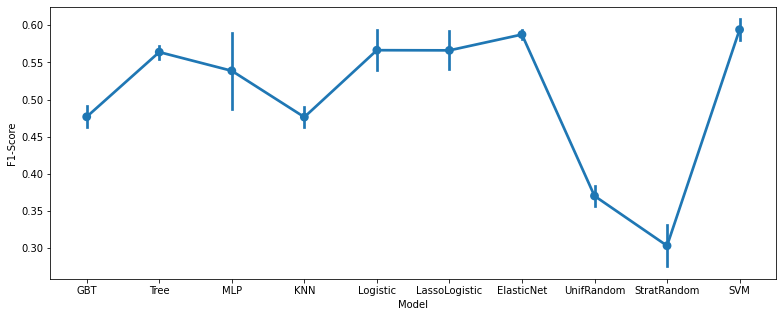

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.pointplot(x="Model", y="F1-Score", data=df_outer_results, ax=ax)

We will now proceed to analyse the models across all the metrics chosen. 

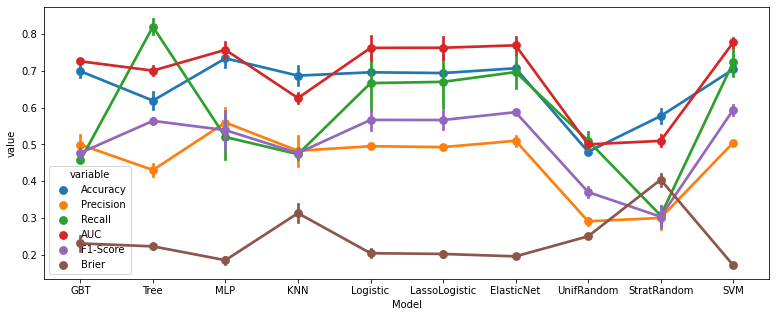

In [ ]:
df_melt = df_outer_results.melt(id_vars=["Model"], value_vars=list(perf_metrics.keys()))
fig, ax = plt.subplots(1,1,figsize=(13,5))
sns.pointplot(x="Model", y="value", hue="variable", data=df_melt, ax=ax)

In [ ]:
a = df_outer_results.pivot_table(index=["Model"], aggfunc="mean")
a[["Brier"]] = 1 - a[["Brier"]]
a.rank().mean(axis=1).sort_values(ascending=False)

Model
SVM              9.166667
ElasticNet       8.666667
MLP              7.500000
LassoLogistic    6.500000
Logistic         6.500000
Tree             5.166667
GBT              4.833333
KNN              3.166667
UnifRandom       2.000000
StratRandom      1.500000
dtype: float64

We take into account the ranking of each algorithm under each performance metric, and aggregate the results. We can see that SVM is the algorithm which performs best consistently across all measures. 